In [ ]:
%pip install importlib-metadata==4.9.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.13.0
    Uninstalling importlib-metadata-4.13.0:
      Successfully uninstalled importlib-metadata-4.13.0


In [ ]:
import pdb
import glob
import math
import numba
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import tensorflow as tf 
import matplotlib as mpl
import mpl_toolkits.mplot3d 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cmath import inf
from scipy import stats
from matplotlib import cm
from sklearn import datasets
from tensorflow.keras import datasets, layers, models, utils
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

from google.colab import drive, data_table
drive.mount('/content/drive', force_remount=True)

"""
Autor: Sebastian Carmona
"""

Mounted at /content/drive


'\nAutor: Sebastian Carmona\n'

### Funciones auxiliares

In [ ]:
def fromtimestamp_vec(ds_time):
  funct_ = np.vectorize(dt.datetime.fromtimestamp)
  return funct_(ds_time)



In [ ]:
def apply_fft_ds(ds, channel:str='rcs_0', coord_name:str = 'range'):
  """
  Get the numpy fast fourier transform to the lidar profiles and append them to
  the dataset ds.

  Parameters:
  ----------
  ds: xarray.Dataset
    - Dataset to get the np.fft
  channel: str
    - Variable name of the variable to retrieve the np.fft
  coord_name: str
    - Coord name of the coordinate to retrieve de np.fft

  Returns:
  --------
  out: xarray.Dataset
    - Original Dataset ds with the np.fft and the frequencies coord saved.
  """

  coord_units = ds[coord_name].units
  channel_FT = xr.apply_ufunc(np.fft.fft, ds[channel])
  dfreqs = (1/max(ds[coord_name])).data
  out = ds.assign_coords({'freqs': ('freqs', np.arange(0, dfreqs*len(ds[coord_name]), dfreqs), {'units': '1/{}'.format(coord_units), 'long_name': 'frequencies'})})
  out = out.assign({'{}_fft'.format(channel): ({'time':out.time, 'freqs':out.freqs}, channel_FT.data, {'long_name': 'Fast Fourier transform of {}'.format(ds[channel].attrs['long_name'])})})
  # out = out['{}_fft'.format(channel)].assign_coords(freqs=out.freqs)
  # pdb.set_trace()

  return out

def dataarray_magnitude(da):
  """
  Get the magnitude of a xarray.Dataaray da with complex numbers
  """
  out = xr.apply_ufunc(np.real, ds.rcs_0_fft)**2 + xr.apply_ufunc(np.real, ds.rcs_0_fft) **2
  return xr.apply_ufunc(np.sqrt, out)


In [ ]:
@numba.jit(nopython=True)
def euclidean(x, x2):
  # pdb.set_trace()
  return [np.sqrt(np.sum((xi - x2)**2)) for xi in x]
  # return np.sqrt(np.sum((x1 - x2)**2))

@numba.jit(nopython=True)
def mahalanobis(x, x2):
  x_cov = np.cov(x, rowvar=False).reshape((x.shape[1], x.shape[1]))
  # x_mean = x.mean(axis=0)
  # pdb.set_trace()
  # return [(xi - x_mean).transpose() @ np.linalg.inv(x_cov) @ (xi - x_mean) for xi in x]
  return [(xi - x2).transpose() @ np.linalg.inv(x_cov) @ (xi - x2) for xi in x]

@numba.jit(nopython=True)
def manhattan(x, x2):
  # x_mean = x.mean(axis=0)
  return [np.sum(np.abs(xi - x2)) for xi in x]
@numba.jit(nopython=True)
def cosine(x, x2):
  # x_mean = x.mean(axis=0)
  return [np.sum(xi * x2) / (np.sum(xi)*np.sum(x2)) for xi in x]

@numba.jit(nopython=True)
def cosine_similarity_numba(u:np.ndarray, v:np.ndarray):
    assert(u.shape[0] == v.shape[0])
    uv = 0
    uu = 0
    vv = 0
    for i in range(u.shape[0]):
        uv += u[i]*v[i]
        uu += u[i]*u[i]
        vv += v[i]*v[i]
    cos_theta = 1
    if uu!=0 and vv!=0:
        cos_theta = uv/np.sqrt(uu*vv)
    return cos_theta

In [ ]:
def normalize_ds(ds_variable, operation='normalization', vectorize_flag=True):

  def norm(x):
    # pdb.set_trace()
    return (x - x.min()) / (x.max() - x.min())
  def mahalanobis_transform(X):
    # pdb.set_trace()
    cov = np.cov(X, rowvar=False)
    eigenvalues, U = eig(cov)
    Q = eigenvalues * np.identity(cov.shape[0]) 
    gamma = X @ U.T
    std_gamma = np.std(gamma, axis=0)
    mat_ = (1 / std_gamma) * np.identity(cov.shape[0])
    Z = gamma @ mat_
    return Z

  def standar(x):
    return (x - x.mean()) / x.std()

  if vectorize_flag:
    if operation == 'normalization':
      funct_ = np.vectorize(norm, signature='(i)->(i)')
    elif operation == 'standarization':
      funct_ = np.vectorize(standar, signature='(i)->(i)')
    elif operation == 'mahalanobis':
      ds_ = mahalanobis_transform(ds_variable)
      return ds_ 
    ds_ = xr.apply_ufunc(funct_, ds_variable)
  else:
    if operation == 'normalization':
      funct_ = norm
    elif operation == 'standarization':
      funct_ = standar
    elif operation == 'mahalanobis':
      funct_ = mahalanobis_transform

    ds_ = funct_(ds_variable)

  return ds_

def distance(X, function='euclidian'):
  # def euclidean(x1, x2):
  #  return np.sqrt(np.sum((x1 - x2)**2))
  @numba.jit(nopython=True)
  def euclidean(x, x2):
    # pdb.set_trace()
    return [np.sqrt(np.sum((xi - x2)**2)) for xi in x]
    # return np.sqrt(np.sum((x1 - x2)**2))
  @numba.jit(nopython=True)
  def mahalanobis(x, x2):
    x_cov = np.cov(x, rowvar=False).reshape((x.shape[1], x.shape[1]))
    # x_mean = x.mean(axis=0)
    # pdb.set_trace()
    # return [(xi - x_mean).transpose() @ np.linalg.inv(x_cov) @ (xi - x_mean) for xi in x]
    return [(xi - x2).transpose() @ np.linalg.inv(x_cov) @ (xi - x2) for xi in x]
  # @numba.jit(nopython=True)
  def manhattan(x, x2):
    # x_mean = x.mean(axis=0)
    return [np.sum(np.abs(xi - x2)) for xi in x]
  @numba.jit(nopython=True)
  def cosine(x, x2):
    # x_mean = x.mean(axis=0)
    return [np.sum(xi * x2) / (np.sum(xi)*np.sum(x2)) for xi in x]

  if function == 'euclidian':
    funct = euclidean
  elif function == 'mahalanobis':
    funct = mahalanobis
  elif function == 'manhattan':
    funct = manhattan
  elif function == 'cosine':
    funct = cosine
  
  return np.array([funct(X, x2) for x2 in X])

In [ ]:
def Modelo(method,**kwargs):
    if method == 'svm_linear':
        model = SVC(kernel='linear')
    elif method == 'svm_rbf':
        model = SVC(kernel='rbf')
    elif method == 'svm_polynomial':
        model = SVC(kernel='poly',degree=kwargs['polynomial_degree'])
    elif method == 'linear_regression':
        model = LinearRegression()
    elif method == 'logistic_regression':
        model = LogisticRegression()
    elif method == 'Tree':
        model = DecisionTreeClassifier(max_depth=kwargs['depth'], max_features=kwargs['number_features'])
    return model

def calculate_n(epsilon, delta, method, **kwargs):
    if method=='svm_linear':
        length_H=kwargs['number_features']+1
    elif method=='svm_rbf':
        length_H=inf
    elif method=='svm_polynomial':
        length_H=comb(kwargs['number_features']+kwargs['polynomial_degree']-1,kwargs['polynomial_degree'])+1
    elif method=='linear_regression':
        length_H=kwargs['number_features']+1
    elif method=='logistic_regression':
        length_H=kwargs['number_features']+1

    if method=='Tree':
        n=(np.log(2)/(2*(epsilon)**2))*(((2**kwargs['depth'])-1)*(1+np.log2(kwargs['number_features']))+1+np.log(1/delta))
    else:
        n=((1/epsilon)*(np.log(length_H)+np.log((1/delta))))
    
    if n!=inf:
        n=math.ceil(n)
    
    return n 

def comb(n, k):
  out = int(math.factorial(n) / (math.factorial(k) * math.factorial(n - k)))
  return out

In [ ]:
def site_location(lat=0, lon=0):
  sites = {(48.44424057006836, -4.4123148918151855): 'Brest', 
           (48.77284622192383, 2.012406349182129): 'Trappes'}
  try:
    return sites[(lat, lon)]
  except:
    # return 'Not known site'
    return 'Brest'

def title1(mytitle, coef):
    """
    inclus le titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.95, mytitle, fontsize=6.5*coef, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')
    return


def title2(mytitle, coef):
    """
    inclus le sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.89, mytitle, fontsize=5.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return


def title3(mytitle, coef):
    """
    inclus le sous sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """
    plt.figtext(0.5, 0.85, mytitle, fontsize=4.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return

def gapsizer(ax, time, range, gapsize, colour='#c7c7c7'):
    """
    This function creates a rectangle of color 'colour' when time gap 
    are found in the array 'time'. 
    """
        # search for holes in data
    # --------------------------------------------------------------------
    dif_time = time[1:] - time[0:-1]
    print(type(dif_time))
    for index, delta in enumerate(dif_time):
        # pdb.set_trace()
        if delta > np.timedelta64(gapsize, 'm'):
            # missing hide bad data
            start = mdates.date2num(time[index])
            end = mdates.date2num(time[index + 1])
            width = end - start

            # Plot rectangle
            end = mdates.date2num(time[index + 1])
            rect = mpl.patches.Rectangle(
                (start, 0), width, np.nanmax(range),
                color=colour)
            ax.add_patch(rect)

def plot_as_me(ds, channel, axes, attrs, qt='', wl='', signal_mode='', cmap=mpl.cm.jet, save_fig=False, title=None, **kwargs):
  
  # cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  if title == None:
    title1('MiniMPL {mode} a {wl} {wlu}'.format(instr=attrs['instrument_id'],
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=3)
  else:
    title1(title, coef=2.5)
    

  title2(str(ds.time.values[0].astype('datetime64[D]')), coef=3.5)

  title3('{} ({:.1f}N, {:.1f}E)'.format(site_location(float(ds.station_latitude), float(ds.station_longitude)), 
                                           float(ds.station_latitude), 
                                           float(ds.station_longitude)), coef=3.5)
  
  q = ds[channel].sel(altitude=slice(0, 5000)).plot.pcolormesh(x='time', 
                 y='altitude', 
                 cmap=cmap, 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  q.colorbar.ax.tick_params(labelsize=20)
  q.colorbar.set_label(label=ds[channel].attrs['long_name'] + '\n' + 
                       ds[channel].attrs['units'] , size=20)

  plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0, hspace=0)
  myFmt = mdates.DateFormatter('%Hh')
  axes.xaxis.set_major_formatter(myFmt)
  

  gapsizer(axes, ds.time.values, ds.altitude, gapsize=6, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)


# Radiosonda


In [ ]:
rs_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-rs'
rs_filenames = glob.glob(rs_path + '/*')
filenames = ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc', 
             '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/CEDA/FRANCE/BREST/2018/**/*.nc', recursive=True)
rs_filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-rs/BLH_RS_liss3_BRNliss10_BREST.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-rs/BLH_RS_liss3_BRNliss10_TRAPPES.nc']

In [ ]:
len(filenames)

82

In [ ]:
rs = xr.open_dataset(rs_filenames[0])
rs = rs.assign_coords({'time': ('time', fromtimestamp_vec(rs.time))})

<class 'numpy.ndarray'>


Text(0, 0.5, 'Altitud, m asl')

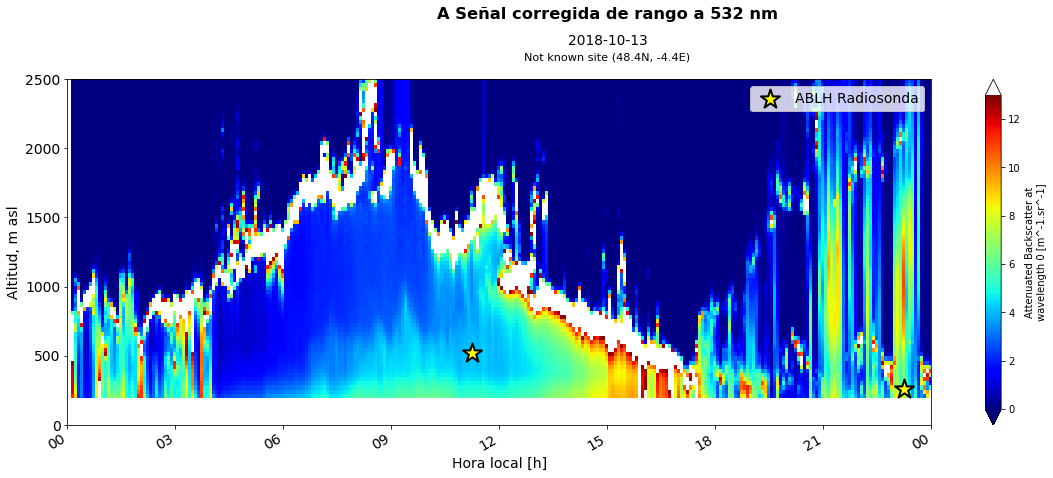

In [ ]:
filename = filenames[3]

date = filename.split('/')[-1].split('.')[0].split('_')[-1]

ds = xr.load_dataset(filename)
# pdb.set_trace()

time_slice = [ds.time[0], ds.time[-1]]
# ds = ds.assign_coords(range=ds.range/1000)
# site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

qt = 'RCS'
wl = '532'
signal_mode = 'Señal corregida de rango'
channel = 'attenuated_backscatter_0'


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds=ds.sel(altitude=slice(0, 2500)), 
          channel=channel, 
          axes=axes, 
          qt=qt, 
          wl=wl,
          signal_mode=signal_mode, 
          attrs=ds.attrs, 
          vmax=13,
          vmin=0,
          )

# xr.plot.scatter(rs.sel(time=slice(*time_slice)), x='time', y='BEST_BLH', ax=axes, s=200, c='red', marker='*', edgecolor='black', linewidth=2)
xr.plot.scatter(rs.sel(time=slice(*time_slice)), x='time', y='BEST_BLH', ax=axes, s=400, c='yellow', marker='*', edgecolor='black', linewidth=2, label='ABLH Radiosonda')

plt.legend(fontsize=14)
# pdb.set_trace()
axes.set_ylim([0, 2500])
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=14)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=14)
axes.set_xlabel('Hora local [h]', fontsize=14)
axes.set_ylabel('Altitud, m asl', fontsize=14)

In [1]:
import time
filename = filenames[9]

date = filename.split('/')[-1].split('.')[0].split('_')[-1]

ds = xr.load_dataset(filename)
ds[channel].attrs['long_name'] = 'Coef. retroesparcimiento atenuado a 532 nm'

time_slice = [ds.time[0], ds.time[-1]]
time_stamp = rs.sel(time=slice(*time_slice)).time[0]
# ds = ds.assign_coords(range=ds.range/1000)
# site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

qt = 'RCS'
wl = '532'
signal_mode = 'Coef. retroesparcimiento atenuado'
channel = 'attenuated_backscatter_0'


fig, axes = plt.subplots(nrows=1, figsize=(24,8))

ax1 = plt.subplot(1,6,(1))
# pdb.set_trace()
ds[channel].sel(time=time_stamp, method='nearest').plot(y='altitude', ax=ax1)
plt.scatter(ds[channel].sel(time=time_stamp, altitude=rs.sel(time=time_stamp).BEST_BLH ,method='nearest').values, rs.sel(time=time_stamp).BEST_BLH, 
            axes=ax1, s=400, c='yellow', marker='*', edgecolor='black', linewidth=2, label='ABLH Radiosonda')


ax2 = plt.subplot(1,6,(2,6), sharey=ax1)

plot_as_me(ds=ds.sel(altitude=slice(0, 2500)), 
          channel=channel, 
          axes=ax2, 
          qt=qt, 
          wl=wl,
          signal_mode=signal_mode, 
          attrs=ds.attrs, 
          vmax=13,
          vmin=0,
          )


endTime = time_stamp.values + np.timedelta64(1, 's')
start = mpl.dates.date2num(time_stamp.values)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 2500, linewidth=3,color='red',fill=False)
ax2.add_patch(rect)

xr.plot.scatter(rs.sel(time=slice(*time_slice)), x='time', y='BEST_BLH', ax=ax2, s=400, c='yellow', marker='*', edgecolor='black', linewidth=2, label='ABLH Radiosonda')

plt.legend(fontsize=14)
# pdb.set_trace()
ax2.set_ylim([200, 2500])
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=20)
ax2.set_xlabel('Hora local [h]', fontsize=20)
ax2.set_ylabel('', fontsize=20)
ax1.set_title('Perfil a las {}h'.format(str(time_stamp.values.astype('datetime64[m]'))[-5:]), fontsize=20)
ax1.set_ylabel('Altitud, m asl', fontsize=20)
ax1.set_xlabel('Coef.\n Retroesparcimiento\n atenuado', fontsize=20)
# ax1.set_xlim([-1, 13])
o_ = plt.setp(ax2.get_yticklabels(), visible=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.82,
                    wspace=0.2,
                    hspace=0.4)

NameError: ignored